<a href="https://colab.research.google.com/github/nextgencodes/welding_defects/blob/main/welding_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welding Defect Classification

In this notebook, we build a deep learning model to classify images of welds as defective or not defective. We make use of a pre-trained model with transfer learning.

### Load Libraries

Load necessary libraries, and optionally install missing requirements.  If any other needed libraries are not installed, please install them with `!pip install <library name>`.

We also print out some data about the environment and set the seed.

In [1]:
!git clone https://github.com/nextgencodes/welding_defects.git
!unzip welding_defects/Data.zip -d welding_defects

Cloning into 'welding_defects'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.
Archive:  welding_defects/Data.zip
   creating: welding_defects/Data/binary_128x128_2000train/
   creating: welding_defects/Data/binary_128x128_2000train/test/
   creating: welding_defects/Data/binary_128x128_2000train/test/0/
 extracting: welding_defects/Data/binary_128x128_2000train/test/0/olabel_0_al5083_test_170905-112213-Al 2mm_frame_00163.png  
 extracting: welding_defects/Data/binary_128x128_2000train/test/0/olabel_0_al5083_test_170905-112213-Al 2mm_frame_00169.png  
 extracting: welding_defects/Data/binary_128x128_2000train/test/0/olabel_0_al5083_test_170905-112213-Al 2mm_frame_00172.png  
 extracting: welding_defects/Data/binary_128x128_2000train/test/0/olabel_0_al5083_test_170905-112213-Al 2mm_frame_00177.png  
 extract

In [2]:
# # Install the following libraries with pip, if not already available:
!pip install matplotlib
!pip install tf2onnx

import os

import numpy as np
from numpy.random import seed
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras import applications, layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef, accuracy_score
from PIL import Image

import tf2onnx
import onnx

from time import perf_counter

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 442 kB 16.8 MB/s 
     |████████████████████████████████| 13.1 MB 60.3 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0.7
    Uninstalling flatbuffers-2.0.7:
      Successfully uninstalled flatbuffers-2.0.7


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9399751066393234777
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14444920832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10209415081518930400
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
# Print library versions
print('numpy:', np.__version__)
print('tensorflow:', tf.__version__)

# Print backend and image data format
print('backend:', K.backend())
print('image data format:', K.image_data_format())

# Set seed 
seed(1)
tf.compat.v1.set_random_seed(2)

numpy: 1.21.6
tensorflow: 2.8.2
backend: tensorflow
image data format: channels_last


### Define functions and set environment and model training variables

In [5]:
def plot_history(model_hist):
    '''Given model training data, plot the model training history.'''
    plt.plot(model_hist.history['accuracy'])
    plt.plot(model_hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    return

def print_performance(y_truth, y_pred_class):
    '''Given ground truth and predicted labels, print the performance of the model:
        - Confusion Matrix
        - Accuracy
        - Matthews Correlation Coefficient
    '''
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_truth, y_pred_class))

    print("Accuracy: {0:.4f}".format(accuracy_score(y_truth, y_pred_class)))
    print("MCC:      {0:.4f}".format(matthews_corrcoef(y_truth, y_pred_class)))
    return


def list_files(path):
    '''List files recursively for a given path. Use full path for each file.'''
    files = []
    for r, d, f in os.walk(path):
        for file in f:
            files.append(os.path.join(r, file))
    return files

def print_pil_img_info(an_img_path):
    '''Print info for image opened with PIL Image'''
    an_img = Image.open(an_img_path)
    print("format:", an_img.format)
    print("mode:", an_img.mode)
    print("size:", an_img.size)

The data used for model training is contained in the folder `binary_128x128_2000train`. This folder contains sub-folders `test`, `train`, and `val`.

In [6]:
# Print the data directory structure
print(os.listdir("welding_defects/Data"))
print(os.listdir("welding_defects/Data/binary_128x128_2000train"))

# Set folder variables
proj_dir = "."
dataset_base_dir = 'welding_defects/Data/binary_128x128_2000train/'
TRAIN_DIR = dataset_base_dir + 'train'
VAL_DIR = dataset_base_dir + 'val'
TEST_DIR = dataset_base_dir + 'test'

# Get number of samples in each folder
num_train_samples = len(list_files(os.path.join(proj_dir, TRAIN_DIR)))
num_val_samples = len(list_files(os.path.join(proj_dir, VAL_DIR)))
num_test_samples = len(list_files(os.path.join(proj_dir, TEST_DIR)))

['testNoDefectImage.png', 'testDefectImage.png', 'binary_128x128_2000train']
['val', 'test', 'train']


### Check data
The data is split into training, validation, and test sets. The train set is used to train the model, and validation set is used to check performance during training. The test set is held out until the end to check final model performance.

To get an idea of what the data looks like, we load a sample image from the training folder and print its metadata.

2000 600 600


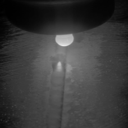

format: PNG
mode: L
size: (128, 128)


In [7]:
# Print the number of images in train, validation, and test directories
print(num_train_samples, num_val_samples, num_test_samples)

# Load an image and print image metadata
from PIL import Image
sample_img_path = list_files(os.path.join(proj_dir, TRAIN_DIR))[0]

sample_img = Image.open(sample_img_path)
display(sample_img)
print_pil_img_info(sample_img_path)

### Define data generators

Define the data generators used during training and testing. The training data generator includes a few transformations that are applied to images during training.

In [8]:
# Set model training variables
batch_size = 32
tile_size = (128,128) 

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect')

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=tile_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode = 'rgb')

validation_generator = test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=tile_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode = 'rgb')

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = tile_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False)

# plot_losses = PlotLosses()

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


### Define model

We start with a MobileNet model and modify it for our needs.

In [9]:
model_lst = [applications.DenseNet121,
             applications.Xception,
             applications.InceptionResNetV2,
             applications.VGG19,
             applications.MobileNet,
             applications.EfficientNetV2B0]

##################################################### DenseNet121 ###################################################
29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/15
62/62 [==============================] - 31s 190ms/step - loss: 0.4585 - accuracy: 0.8354 - val_loss: 0.2737 - val_accuracy: 0.9115
Epoch 2/15
62/62 [==============================] - 9s 152ms/step - loss: 0.3042 - accuracy: 0.8847 - val_loss: 0.2169 - val_accuracy: 0.9375
Epoch 3/15
62/62 [==============================] - 9s 152ms/step - loss: 0.2557 - accuracy: 0.9045 - val_loss: 0.1784 - val_accuracy: 0.9410
Epoch 4/15
62/62 [==============================] - 9s 152ms/step - loss: 0.2261 - accuracy: 0.9146 - val_loss: 0.1820 - val_accuracy: 0.9462
Epoch 5/15
62/62 [==============================] - 10s 163ms/step - loss: 0.2278 - accuracy: 0.9197 - val_loss: 0.1370 - val_accuracy: 0.9462
Epoch 6/15
62/62 [==============================] - 10s 153ms/step - loss: 0.1882 - accuracy: 0.9294 - va

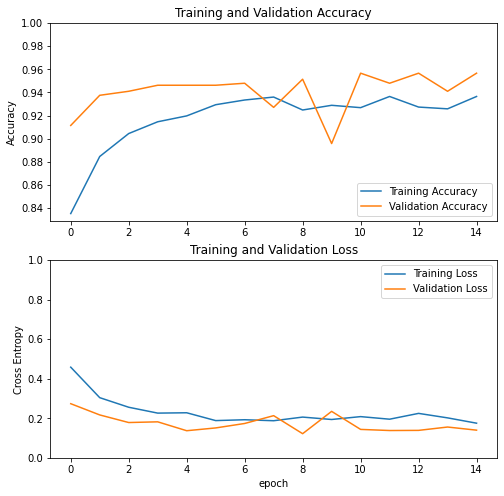


Model performance on test dataset:

Confusion Matrix:
[[296   4]
 [ 56 244]]
Accuracy: 0.9000
MCC:      0.8123
364
221
Epoch 15/30
62/62 [==============================] - 22s 198ms/step - loss: 0.7854 - accuracy: 0.8989 - val_loss: 0.6328 - val_accuracy: 0.9010
Epoch 16/30
62/62 [==============================] - 10s 160ms/step - loss: 0.2939 - accuracy: 0.9380 - val_loss: 0.1816 - val_accuracy: 0.9444
Epoch 17/30
62/62 [==============================] - 10s 158ms/step - loss: 0.1837 - accuracy: 0.9588 - val_loss: 0.0632 - val_accuracy: 0.9774
Epoch 18/30
62/62 [==============================] - 10s 158ms/step - loss: 0.1613 - accuracy: 0.9644 - val_loss: 0.0677 - val_accuracy: 0.9826
Epoch 19/30
62/62 [==============================] - 10s 160ms/step - loss: 0.0994 - accuracy: 0.9751 - val_loss: 0.1226 - val_accuracy: 0.9757
Epoch 20/30
62/62 [==============================] - 10s 161ms/step - loss: 0.1047 - accuracy: 0.9792 - val_loss: 0.0267 - val_accuracy: 0.9896
Epoch 21/30
62/6

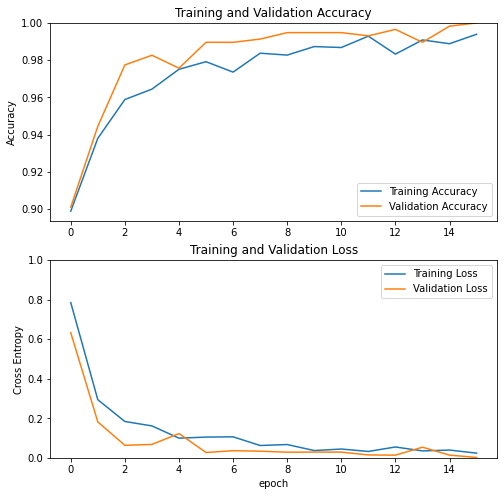


Model performance on test dataset:

Confusion Matrix:
[[289  11]
 [ 61 239]]
Accuracy: 0.8800
MCC:      0.7708
##################################################### Xception ###################################################
83697664/83683744 [==============================] - 0s 0us/step
Epoch 1/15
62/62 [==============================] - 14s 171ms/step - loss: 0.4014 - accuracy: 0.8232 - val_loss: 0.2631 - val_accuracy: 0.8837
Epoch 2/15
62/62 [==============================] - 9s 152ms/step - loss: 0.2855 - accuracy: 0.8826 - val_loss: 0.5125 - val_accuracy: 0.8090
Epoch 3/15
62/62 [==============================] - 9s 152ms/step - loss: 0.2767 - accuracy: 0.8755 - val_loss: 0.2129 - val_accuracy: 0.9097
Epoch 4/15
62/62 [==============================] - 10s 153ms/step - loss: 0.2336 - accuracy: 0.9080 - val_loss: 0.2751 - val_accuracy: 0.8854
Epoch 5/15
62/62 [==============================] - 9s 151ms/step - loss: 0.2079 - accuracy: 0.9116 - val_loss: 0.2211 - val_accuracy: 0.9

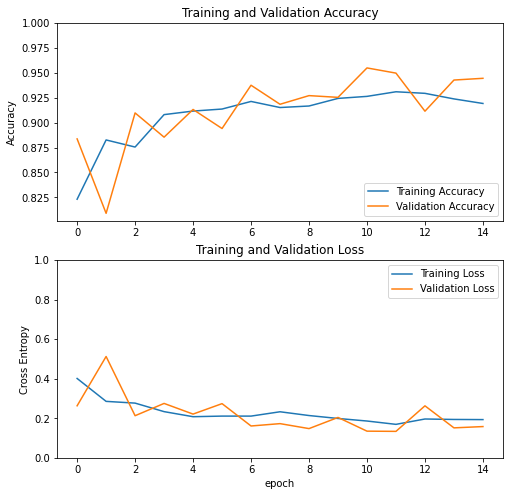


Model performance on test dataset:

Confusion Matrix:
[[262  38]
 [ 62 238]]
Accuracy: 0.8333
MCC:      0.6688
156
97
Epoch 15/30
62/62 [==============================] - 15s 181ms/step - loss: 0.4555 - accuracy: 0.8598 - val_loss: 0.4374 - val_accuracy: 0.8976
Epoch 16/30
62/62 [==============================] - 10s 167ms/step - loss: 0.1949 - accuracy: 0.9299 - val_loss: 0.3456 - val_accuracy: 0.9219
Epoch 17/30
62/62 [==============================] - 11s 181ms/step - loss: 0.1297 - accuracy: 0.9538 - val_loss: 0.1881 - val_accuracy: 0.9340
Epoch 18/30
62/62 [==============================] - 10s 168ms/step - loss: 0.0868 - accuracy: 0.9660 - val_loss: 0.0732 - val_accuracy: 0.9705
Epoch 19/30
62/62 [==============================] - 10s 166ms/step - loss: 0.0694 - accuracy: 0.9771 - val_loss: 0.1414 - val_accuracy: 0.9670
Epoch 20/30
62/62 [==============================] - 11s 168ms/step - loss: 0.0781 - accuracy: 0.9797 - val_loss: 0.0596 - val_accuracy: 0.9792
Epoch 21/30
62/62

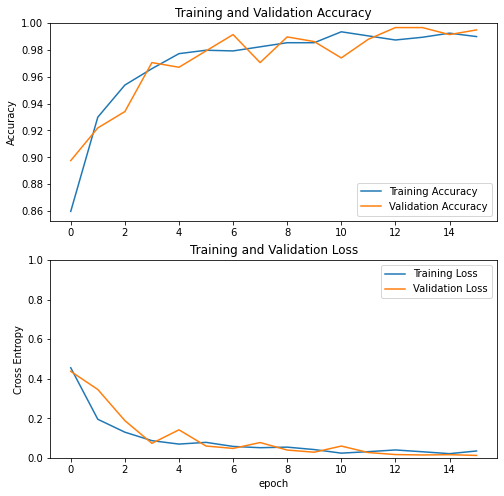


Model performance on test dataset:

Confusion Matrix:
[[292   8]
 [ 25 275]]
Accuracy: 0.9450
MCC:      0.8914
##################################################### InceptionResNetV2 ###################################################
219070464/219055592 [==============================] - 1s 0us/step
Epoch 1/15
62/62 [==============================] - 24s 226ms/step - loss: 0.5828 - accuracy: 0.7886 - val_loss: 0.3028 - val_accuracy: 0.8733
Epoch 2/15
62/62 [==============================] - 11s 171ms/step - loss: 0.3961 - accuracy: 0.8648 - val_loss: 0.2068 - val_accuracy: 0.9132
Epoch 3/15
62/62 [==============================] - 11s 170ms/step - loss: 0.3391 - accuracy: 0.8836 - val_loss: 0.2255 - val_accuracy: 0.9080
Epoch 4/15
62/62 [==============================] - 11s 169ms/step - loss: 0.3098 - accuracy: 0.8872 - val_loss: 0.2294 - val_accuracy: 0.9132
Epoch 5/15
62/62 [==============================] - 11s 171ms/step - loss: 0.3085 - accuracy: 0.8948 - val_loss: 0.1834 - val

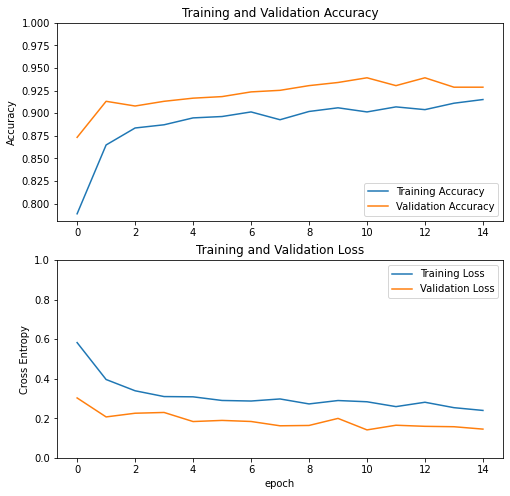


Model performance on test dataset:

Confusion Matrix:
[[254  46]
 [ 27 273]]
Accuracy: 0.8783
MCC:      0.7582
490
294
Epoch 15/30
62/62 [==============================] - 30s 255ms/step - loss: 0.3550 - accuracy: 0.8425 - val_loss: 0.3684 - val_accuracy: 0.9323
Epoch 16/30
62/62 [==============================] - 12s 198ms/step - loss: 0.2014 - accuracy: 0.9131 - val_loss: 0.1867 - val_accuracy: 0.9479
Epoch 17/30
62/62 [==============================] - 13s 201ms/step - loss: 0.1548 - accuracy: 0.9355 - val_loss: 0.0989 - val_accuracy: 0.9670
Epoch 18/30
62/62 [==============================] - 13s 202ms/step - loss: 0.1066 - accuracy: 0.9553 - val_loss: 0.0684 - val_accuracy: 0.9705
Epoch 19/30
62/62 [==============================] - 13s 201ms/step - loss: 0.0860 - accuracy: 0.9680 - val_loss: 0.0477 - val_accuracy: 0.9774
Epoch 20/30
62/62 [==============================] - 13s 201ms/step - loss: 0.0652 - accuracy: 0.9787 - val_loss: 0.0412 - val_accuracy: 0.9826
Epoch 21/30
62/6

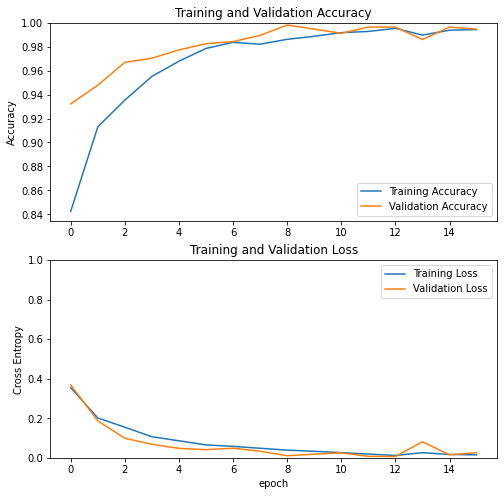


Model performance on test dataset:

Confusion Matrix:
[[264  36]
 [ 11 289]]
Accuracy: 0.9217
MCC:      0.8463
##################################################### VGG19 ###################################################
80150528/80134624 [==============================] - 1s 0us/step
Epoch 1/15
62/62 [==============================] - 13s 177ms/step - loss: 0.6665 - accuracy: 0.6291 - val_loss: 0.4427 - val_accuracy: 0.8281
Epoch 2/15
62/62 [==============================] - 10s 161ms/step - loss: 0.4525 - accuracy: 0.7962 - val_loss: 0.3474 - val_accuracy: 0.8455
Epoch 3/15
62/62 [==============================] - 10s 161ms/step - loss: 0.3925 - accuracy: 0.8252 - val_loss: 0.3017 - val_accuracy: 0.8854
Epoch 4/15
62/62 [==============================] - 10s 162ms/step - loss: 0.3607 - accuracy: 0.8420 - val_loss: 0.2785 - val_accuracy: 0.8993
Epoch 5/15
62/62 [==============================] - 10s 160ms/step - loss: 0.3297 - accuracy: 0.8572 - val_loss: 0.2648 - val_accuracy: 0.9

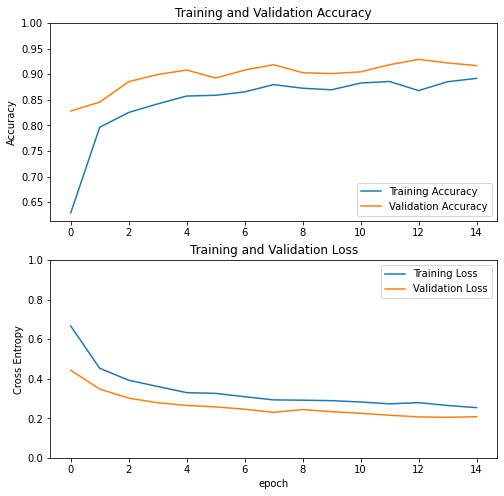


Model performance on test dataset:

Confusion Matrix:
[[275  25]
 [ 39 261]]
Accuracy: 0.8933
MCC:      0.7875
34
24
Epoch 15/30
62/62 [==============================] - 14s 191ms/step - loss: 0.8568 - accuracy: 0.4970 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 16/30
62/62 [==============================] - 11s 179ms/step - loss: 0.6938 - accuracy: 0.5015 - val_loss: 0.6929 - val_accuracy: 0.5052
Epoch 17/30
62/62 [==============================] - 11s 181ms/step - loss: 0.6953 - accuracy: 0.4842 - val_loss: 0.6928 - val_accuracy: 0.6562
Epoch 18/30
62/62 [==============================] - 12s 194ms/step - loss: 0.6936 - accuracy: 0.4914 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 19/30
62/62 [==============================] - 11s 181ms/step - loss: 0.6938 - accuracy: 0.4848 - val_loss: 0.6931 - val_accuracy: 0.4965
Epoch 20/30
62/62 [==============================] - 11s 178ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4965
Epoch 21/30
62/62 

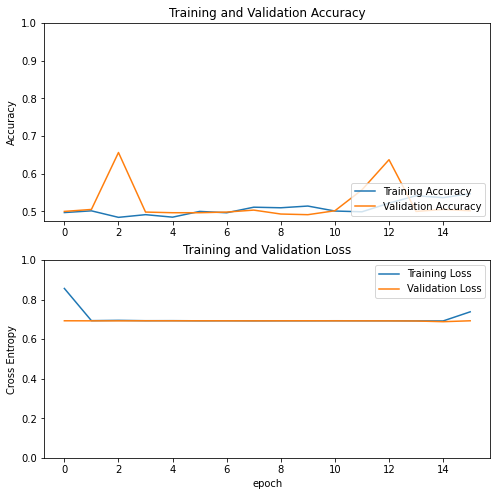


Model performance on test dataset:

Confusion Matrix:
[[  0 300]
 [  0 300]]
Accuracy: 0.5000
MCC:      0.0000
##################################################### MobileNet ###################################################
17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/15
62/62 [==============================] - 11s 147ms/step - loss: 0.4406 - accuracy: 0.8664 - val_loss: 0.1618 - val_accuracy: 0.9462
Epoch 2/15
62/62 [==============================] - 9s 142ms/step - loss: 0.2093 - accuracy: 0.9314 - val_loss: 0.1242 - val_accuracy: 0.9601
Epoch 3/15
62/62 [==============================] - 9s 141ms/step - loss: 0.1723 - accuracy: 0.9451 - val_loss: 0.1034 - val_accuracy: 0.9635
Epoch 4/15
62/62 [==============================] - 9s 141ms/step - loss: 0.1649 - accuracy: 0.9472 - val_loss: 0.1088 - val_accuracy: 0.9653
Epoch 5/15
62/62 [==============================] - 9s 141ms/step - loss: 0.1585 - accuracy: 0.9507 - val_loss: 0.0928 - val_accuracy: 0.9

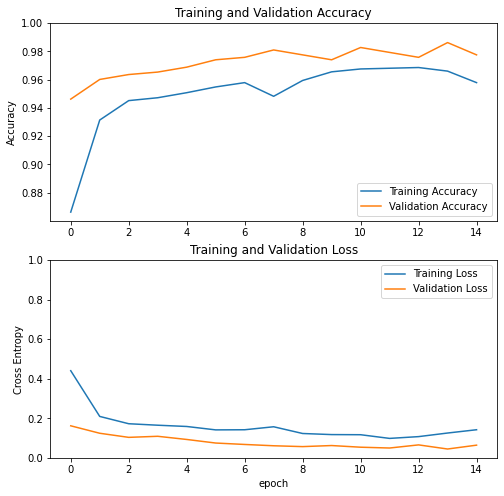


Model performance on test dataset:

Confusion Matrix:
[[245  55]
 [ 17 283]]
Accuracy: 0.8800
MCC:      0.7662
83
52
Epoch 15/30
62/62 [==============================] - 12s 154ms/step - loss: 1.7351 - accuracy: 0.8796 - val_loss: 0.1813 - val_accuracy: 0.9566
Epoch 16/30
62/62 [==============================] - 9s 149ms/step - loss: 0.2760 - accuracy: 0.9558 - val_loss: 0.1144 - val_accuracy: 0.9705
Epoch 17/30
62/62 [==============================] - 10s 165ms/step - loss: 0.1398 - accuracy: 0.9746 - val_loss: 0.0617 - val_accuracy: 0.9826
Epoch 18/30
62/62 [==============================] - 9s 146ms/step - loss: 0.1593 - accuracy: 0.9721 - val_loss: 0.0671 - val_accuracy: 0.9844
Epoch 19/30
62/62 [==============================] - 9s 147ms/step - loss: 0.1103 - accuracy: 0.9832 - val_loss: 0.0817 - val_accuracy: 0.9896
Epoch 20/30
62/62 [==============================] - 9s 147ms/step - loss: 0.1783 - accuracy: 0.9731 - val_loss: 0.0607 - val_accuracy: 0.9896
Epoch 21/30
62/62 [===

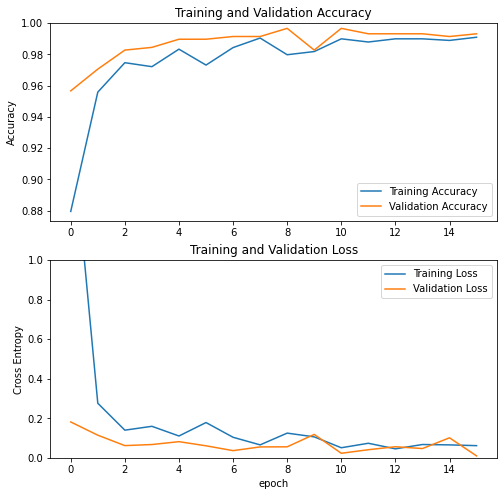


Model performance on test dataset:

Confusion Matrix:
[[288  12]
 [ 32 268]]
Accuracy: 0.9267
MCC:      0.8552
##################################################### EfficientNetV2B0 ###################################################
24289280/24274472 [==============================] - 0s 0us/step
Epoch 1/15
62/62 [==============================] - 17s 173ms/step - loss: 0.8109 - accuracy: 0.5112 - val_loss: 0.7695 - val_accuracy: 0.5017
Epoch 2/15
62/62 [==============================] - 9s 148ms/step - loss: 0.7858 - accuracy: 0.4832 - val_loss: 0.7222 - val_accuracy: 0.4931
Epoch 3/15
62/62 [==============================] - 9s 148ms/step - loss: 0.7579 - accuracy: 0.4934 - val_loss: 0.9468 - val_accuracy: 0.5017
Epoch 4/15
62/62 [==============================] - 9s 148ms/step - loss: 0.7603 - accuracy: 0.4949 - val_loss: 0.7952 - val_accuracy: 0.5000
Epoch 5/15
62/62 [==============================] - 9s 147ms/step - loss: 0.7523 - accuracy: 0.5208 - val_loss: 0.8144 - val_accura

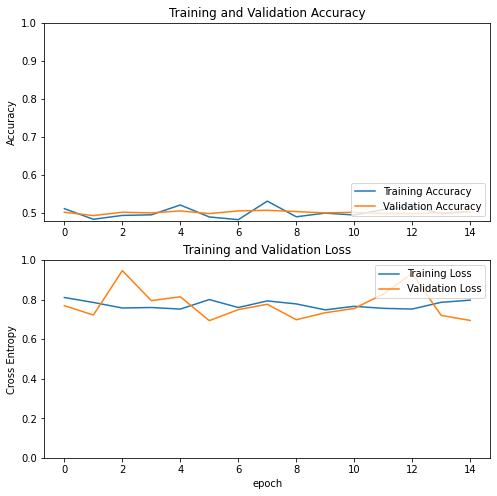


Model performance on test dataset:

Confusion Matrix:
[[300   0]
 [300   0]]
Accuracy: 0.5000
MCC:      0.0000
243
145
Epoch 15/30
62/62 [==============================] - 19s 181ms/step - loss: 0.8120 - accuracy: 0.6301 - val_loss: 0.5639 - val_accuracy: 0.6892
Epoch 16/30
62/62 [==============================] - 10s 157ms/step - loss: 0.6382 - accuracy: 0.6905 - val_loss: 0.7124 - val_accuracy: 0.6354
Epoch 17/30
62/62 [==============================] - 10s 157ms/step - loss: 0.5047 - accuracy: 0.7718 - val_loss: 1.5183 - val_accuracy: 0.5035
Epoch 18/30
62/62 [==============================] - 10s 159ms/step - loss: 0.5075 - accuracy: 0.7785 - val_loss: 0.9039 - val_accuracy: 0.5260
Epoch 19/30
62/62 [==============================] - 10s 158ms/step - loss: 0.4575 - accuracy: 0.7891 - val_loss: 0.6369 - val_accuracy: 0.7396
Epoch 20/30
62/62 [==============================] - 10s 158ms/step - loss: 0.4740 - accuracy: 0.7942 - val_loss: 0.7088 - val_accuracy: 0.7622
Epoch 21/30
62/6

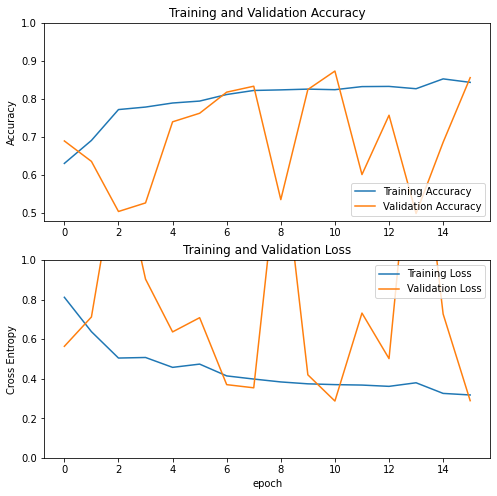


Model performance on test dataset:

Confusion Matrix:
[[ 66 234]
 [ 56 244]]
Accuracy: 0.5167
MCC:      0.0414


In [10]:
nets = len(model_lst)
model = [0]*nets
history_base = [0]*nets
history_fine = [0]*nets

for i,j in enumerate(model_lst):
  filename = str(j).split(" ")[1]

  print("##################################################### {} ###################################################".format(filename))
  # Define base model
  base_model = j(weights = "imagenet",
                                 include_top=False,
                                 input_shape = (tile_size[0], tile_size[1], 3))
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(tile_size) + (3,))
  x = base_model(inputs)
  x = layers.Flatten(name = "flatten")(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(2, activation = 'softmax')(x)

  model[i] = models.Model(inputs, outputs)

  base_learning_rate = 0.001

  model[i].compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer = optimizers.Adam(learning_rate = base_learning_rate),
                metrics = ["accuracy"])

  # Uncomment the following line to see the (long) model summary
  # print(model.summary())
  initial_epochs = 15

  tic = perf_counter()
  history_base[i] = model[i].fit(
          train_generator,
          steps_per_epoch= num_train_samples // batch_size,
          epochs=initial_epochs,
          validation_data=validation_generator,
          validation_steps= num_val_samples // batch_size)
  toc = perf_counter()
  print(f"Trained model in {toc - tic:0.4f} seconds")


  acc = history_base[i].history['accuracy']
  val_acc = history_base[i].history['val_accuracy']

  loss = history_base[i].history['loss']
  val_loss = history_base[i].history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

  y_pred = model[i].predict(test_generator, steps = None)
  y_pred_class = np.array([np.argmax(x) for x in y_pred])
  y_truth = test_generator.classes

  print("\nModel performance on test dataset:")
  print_performance(y_truth, y_pred_class)


  # Fine-tune from this layer onwards
  fine_tune_at = int(len(base_model.layers)*0.4)
  base_model.trainable = True
  print(len(model[i].trainable_variables))

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False

  print(len(model[i].trainable_variables))

  model[i].compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
  
  fine_tune_epochs = 15
  total_epochs =  initial_epochs + fine_tune_epochs

  tic = perf_counter()
  history_fine[i] = model[i].fit(train_generator,
                          steps_per_epoch= num_train_samples // batch_size,
                          epochs=total_epochs,
                          initial_epoch=history_base[i].epoch[-1],
                          validation_data=validation_generator,
                          validation_steps= num_val_samples // batch_size)
  toc = perf_counter()
  print(f"Trained model in {toc - tic:0.4f} seconds")

  acc = history_fine[i].history['accuracy']
  val_acc = history_fine[i].history['val_accuracy']

  loss = history_fine[i].history['loss']
  val_loss = history_fine[i].history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

  y_pred = model[i].predict(test_generator, steps = None)
  y_pred_class = np.array([np.argmax(x) for x in y_pred])
  y_truth = test_generator.classes

  print("\nModel performance on test dataset:")
  print_performance(y_truth, y_pred_class)
  
  model[i].save('{}.h5'.format(filename))


In [11]:
modellist = [0,1,2,4]

In [17]:
!ls -l --block-size=MB

total 1231MB
-rw-r--r-- 1 root root  72MB Sep 27 06:50 DenseNet121.h5
-rw-r--r-- 1 root root  65MB Sep 27 07:24 EfficientNetV2B0.h5
-rw-r--r-- 1 root root 599MB Sep 27 07:06 InceptionResNetV2.h5
-rw-r--r-- 1 root root  39MB Sep 27 07:18 MobileNet.h5
drwxr-xr-x 1 root root   1MB Sep 22 13:42 sample_data
-rw-r--r-- 1 root root 237MB Sep 27 07:13 VGG19.h5
drwxr-xr-x 5 root root   1MB Sep 27 06:44 welding_defects
-rw-r--r-- 1 root root 221MB Sep 27 06:57 Xception.h5


In [18]:
for j in modellist:
    model[j].save('ensemble.h5')